# Modeling
In this notebook, I will load the cleaned, pre-processed data, perform additional data preparations for modeling, and try out a few models to predict negative reviews.

## Setup
### Install TensorFlow 2.0
I chose to use TensorFlow 2.0 to model the dataset. Google Colab does not currently support TensorFlow 2.0. I can work around this by uninstalling TensorFlow and installing TensorFlow 2.0

In [0]:
# !pip uninstall --yes tensorflow
# !pip install tensorflow==2.0.0

Import Python libraries.

In [0]:
from google.colab import drive
from importlib.machinery import SourceFileLoader
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import spacy
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%matplotlib inline

print(f'TensorFlow Version {tf.__version__}')

TensorFlow Version 2.0.0


Mount Google Drive

In [0]:
ROOT = '/content/drive'
PROJECT = 'My Drive/Thinkful/Final_Capstone_Project/'
PROJECT_PATH = os.path.join(ROOT, PROJECT)

In [0]:
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load custom constants and methods.

In [0]:
con = SourceFileLoader('constants', os.path.join(PROJECT_PATH, 'utilities/constants.py')).load_module()
met = SourceFileLoader('methods', os.path.join(PROJECT_PATH, 'utilities/methods.py')).load_module()

## Load Data
Read in the cleaned dataset.

In [0]:
df_clean = pd.read_csv(os.path.join(PROJECT_PATH, 'data/cleaned_full.csv'))

In [0]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608 entries, 0 to 4607
Data columns (total 4 columns):
text          4608 non-null object
clean_text    4608 non-null object
text_seq      4608 non-null object
labels        4608 non-null int64
dtypes: int64(1), object(3)
memory usage: 144.1+ KB


## Data Preparation
Gather features and labels.

In [0]:
X = df_clean['text_seq'].values
y = df_clean['labels'].values

Split dataset into train and test sets.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [0]:
print(f'The fraction of negative reviews in the training set is {np.sum(y_train) / len(y_train):0.3f}.')
print(f'The fraction of negative reviews in the test set is {np.sum(y_test) / len(y_test):0.3f}.')

The fraction of negative reviews in the training set is 0.116.
The fraction of negative reviews in the test set is 0.116.


In [0]:
print(f'Train count: [{len(y_train) - np.sum(y_train)}, {np.sum(y_train)}] ([positive, negative])')

Train count: [3260, 426] ([positive, negative])


In [0]:
print(f'Test count: [{len(y_test) - np.sum(y_test)}, {np.sum(y_test)}] ([positive, negative])')

Test count: [815, 107] ([positive, negative])


In [0]:
y_train_one_hot = y_train.reshape((len(y_train), 1))
y_test_one_hot = y_test.reshape((len(y_test), 1))

### Text Encoding
When modeling this dataset, the words need to be encoded as numbers, since a computer only understands numbers and not strings. I will consider two encoding approaches:

* TF-IDF
* Word Embeddings

#### TF-IDF and Vectorization
For this step, I will use Scikit-Learn's **`TfidfVectorizer()`** to convert the text corpus into feature vectors. This algorithm will first create a vocabulary by finding all of the unique words in the corpus. Each word in each document in the corpus will be assigned a floating point number. This number is comprised of a count of how many times that word is used in the document, weighted by the inverse frequency of that word in the full corpus. Thus, words that are used frequently will be given less weight, while words that are not common will get more weight. This makes sense since words that are used a lot provide little information as related to the outcome variable. For example, if the word _the_ appears in all of the documents, the neural network will have a hard time differntiating between positive and negative reviews.

The **`TfidfVectorizer()`** can be further customized to restrict the vocabulary to a smaller size, such as only including the _n_ most frequent words.

In [0]:
vectorizer = TfidfVectorizer(max_features=2500)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

#### Word Embeddings

In [0]:
max_review_length = np.max([len(x.split()) for x in X_train] + [len(x.split()) for x in X_test])
print(f'The longest cleaned review has {max_review_length} words.')

The longest cleaned review has 422 words.


In [0]:
print(f'The vocabulary size is {con.VOCAB_SIZE}.')

The vocabulary size is 9566.


In [0]:
print(f'The expanded vocabulary size is {con.VOCAB_SIZE*1.5}.')

The expanded vocabulary size is 14349.0.


In [0]:
X_train_encoded = [one_hot(x, con.VOCAB_SIZE*1.5) for x in X_train]
X_test_encoded = [one_hot(x, con.VOCAB_SIZE*1.5) for x in X_test]

In [0]:
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_review_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_review_length, padding='post')

In [0]:
X_train_padded[0][0]

1201

## Class Imbalance
Correct for class imbalance using SMOTE. First, correct the TF-IDF vectors.

In [0]:
X_train_res_vects, y_train_res_vects = SMOTE().fit_resample(X_train_vectorized, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Next, correct training data for word embedding models.

In [0]:
X_train_res_embeds, y_train_res = SMOTE().fit_resample(X_train_padded, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
y_train_res_embeds = y_train_res.reshape((len(y_train_res), 1))

## Modeling
### Simple Model Using TF-IDF Vectores
First, try a very simple Multi-Layer Perceptron model using TF-IDF vectors.

In [0]:
met.set_params(con.PARAMS, 'input_shape', X_test_vectorized.shape[1])
met.set_params(con.PARAMS, 'epochs', 10)
met.set_params(con.PARAMS, 'batch_size', 256)

In [0]:
mlp_model = met.build_mlp_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1280512   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 1,543,681
Trainable params: 1,543,681
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_history = mlp_model.fit(X_train_vectorized,
                        y_train,
                        batch_size=con.PARAMS['batch_size'],
                        epochs=con.PARAMS['epochs'],
                        verbose=0,
                        validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(train_history.history, index=train_history.epoch)

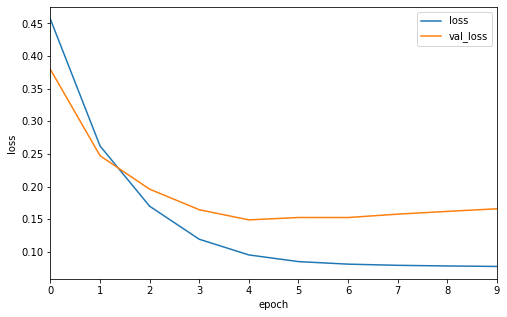

In [0]:
df_train_history.loc[:, ['loss', 'val_loss']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

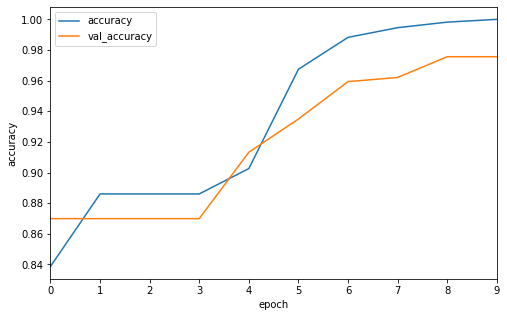

In [0]:
df_train_history.loc[:, ['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [0]:
mlp_test_history = mlp_model.evaluate(X_test_vectorized, y_test, batch_size=con.PARAMS['batch_size'], verbose=0)

In [0]:
met.print_test_results(mlp_model, mlp_test_history)

Test Metrics:
 * Loss: 0.10353528212052882
 * TP: 97.0
 * FP: 0.0
 * TN: 815.0
 * FN: 10.0
 * Accuracy: 0.989154040813446
 * Precision: 1.0
 * Recall: 0.9065420627593994
 * AUC: 0.9951149821281433


In [0]:
con.PREDICTIONS['mlp'] = mlp_model.predict_classes(X_test_vectorized)

This simple model performed quite well. It predicted zero false positives, meaning it can accurately predict negative reviews.

#### Oversampled Training Set
Repeat the model fit, but use the oversampled training set.

In [0]:
met.set_params(con.PARAMS, 'epochs', 3)

In [0]:
mlp_res_model = met.build_mlp_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1280512   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 1,543,681
Trainable params: 1,543,681
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_history = mlp_res_model.fit(X_train_res_vects, 
                          y_train_res_vects,
                          batch_size=con.PARAMS['batch_size'],
                          epochs=con.PARAMS['epochs'],
                          verbose=0,
                          validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(train_history.history, index=train_history.epoch)

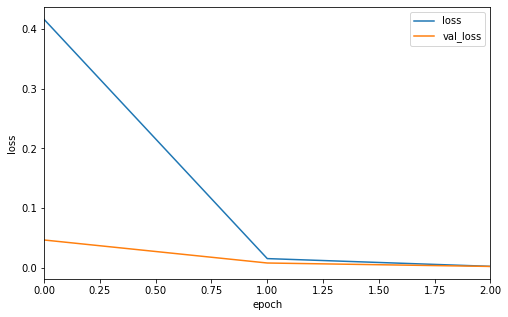

In [0]:
df_train_history.loc[:, ['loss', 'val_loss']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

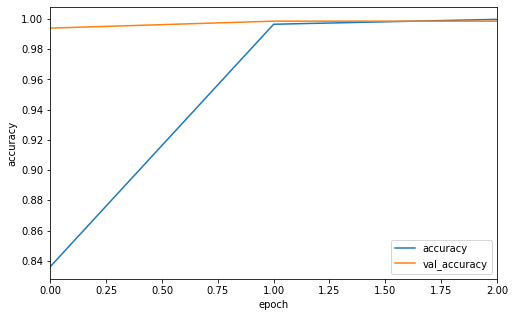

In [0]:
df_train_history.loc[:, ['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [0]:
mlp_res_test_history = mlp_res_model.evaluate(X_test_vectorized, y_test, batch_size=con.PARAMS['batch_size'], verbose=0)

In [0]:
met.print_test_results(mlp_res_model, mlp_res_test_history)

Test Metrics:
 * Loss: 0.005294940415204153
 * TP: 106.0
 * FP: 0.0
 * TN: 815.0
 * FN: 1.0
 * Accuracy: 0.9989153742790222
 * Precision: 1.0
 * Recall: 0.9906542301177979
 * AUC: 0.9999885559082031


In [0]:
con.PREDICTIONS['mlp_res'] = mlp_res_model.predict_classes(X_test_vectorized)

### LSTM Model
Try using a recurrent neural network LSTM model to predict positive and negative reviews. In this model, I will use the custom word embeddings I created, instead of the TF-IDF vectors.

In [0]:
met.set_params(con.PARAMS, 'epochs', 3)
met.set_params(con.PARAMS, 'batch_size', 32)
met.set_params(con.PARAMS, 'vocab_size', int(con.VOCAB_SIZE*1.5))
met.set_params(con.PARAMS, 'embedding_size', 128)
met.set_params(con.PARAMS, 'input_length', max_review_length)
met.set_params(con.PARAMS, 'lstm_units', 200)
met.set_params(con.PARAMS, 'drop_out_prob', 0.2)

In [0]:
lstm_model = met.build_lstm_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 422, 128)          1836672   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               263200    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 2,100,073
Trainable params: 2,100,073
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_history = lstm_model.fit(X_train_padded, 
                         y_train_one_hot, 
                         batch_size=con.PARAMS['batch_size'], 
                         epochs=con.PARAMS['epochs'], 
                         verbose=0, 
                         validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(lstm_history.history, index=lstm_history.epoch)

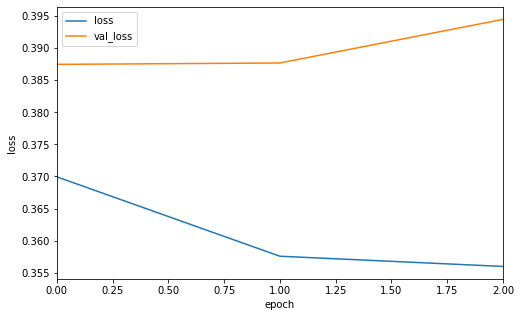

In [0]:
df_train_history.loc[:, ['loss', 'val_loss']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

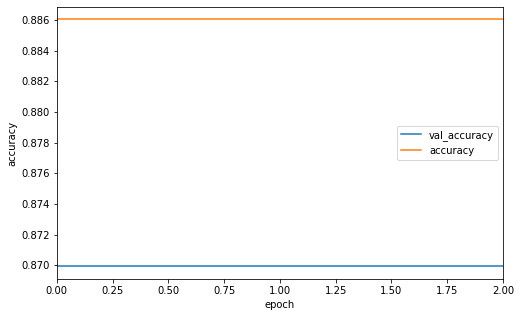

In [0]:
df_train_history.loc[:, ['val_accuracy', 'accuracy']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [0]:
lstm_test_history = lstm_model.evaluate(X_test_padded, y_test_one_hot, batch_size=con.PARAMS['batch_size'], verbose=0)

In [0]:
met.print_test_results(lstm_model, lstm_test_history)

Test Metrics:
 * Loss: 0.3628070888446882
 * TP: 0.0
 * FP: 0.0
 * TN: 815.0
 * FN: 107.0
 * Accuracy: 0.8839479684829712
 * Precision: 0.0
 * Recall: 0.0
 * AUC: 0.4981594979763031


In [0]:
con.PREDICTIONS['lstm'] = lstm_model.predict_classes(X_test_padded)

This model is doing a horrible job. It predicts that all reviews are positive and that there are no negative reviews. This is an example for why an LSTM-style model will not work for this problem statement. LSTMs are great at learning a sequence of values and predicting future values in the sequence. While the reviews are a sequence of text, the problem statement is to classify the text as positive or negative, and not to predict future values in the text.

### Simple Model using Embeddings
Here, I will try a simple, feed forward model using word embeddings. I will use the custom embeddings that I created earlier.

In [0]:
met.set_params(con.PARAMS, 'vocab_size', int(con.VOCAB_SIZE*1.5))
met.set_params(con.PARAMS, 'embedding_size', 128)
met.set_params(con.PARAMS, 'input_length', max_review_length)
met.set_params(con.PARAMS, 'epochs', 5)
met.set_params(con.PARAMS, 'batch_size', 128)

In [0]:
embed_model = met.build_embedding_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 422, 128)          1836672   
_________________________________________________________________
flatten (Flatten)            (None, 54016)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               13504250  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 15,341,173
Trainable params: 15,341,173
Non-trainable params: 0
_________________________________________________________________


In [0]:
embedding_history = embed_model.fit(X_train_padded,
                              y_train_one_hot, 
                              batch_size=con.PARAMS['batch_size'],
                              epochs=con.PARAMS['epochs'], 
                              verbose=0,
                              validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(embedding_history.history, index=embedding_history.epoch)

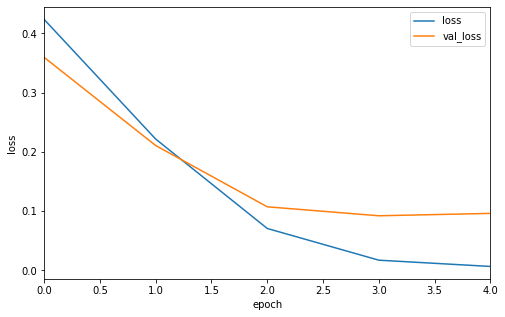

In [0]:
df_train_history.loc[:, ['loss', 'val_loss']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

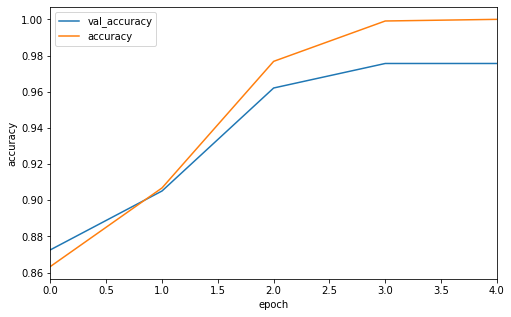

In [0]:
df_train_history.loc[:, ['val_accuracy', 'accuracy']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [0]:
embed_test_history = embed_model.evaluate(X_test_padded, 
                                    y_test_one_hot, 
                                    batch_size=con.PARAMS['batch_size'], 
                                    verbose=0)

In [0]:
met.print_test_results(embed_model, embed_test_history)

Test Metrics:
 * Loss: 0.047918643974123314
 * TP: 97.0
 * FP: 3.0
 * TN: 812.0
 * FN: 10.0
 * Accuracy: 0.9859002232551575
 * Precision: 0.9700000286102295
 * Recall: 0.9065420627593994
 * AUC: 0.9972478151321411


In [0]:
con.PREDICTIONS['embed'] = embed_model.predict_classes(X_test_padded)

#### Oversampled Training Set
Repeat the model fit, but use the oversampled training set.

In [0]:
embed_res_model = met.build_embedding_model(metrics=con.METRICS, params=con.PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 422, 128)          1836672   
_________________________________________________________________
flatten (Flatten)            (None, 54016)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               13504250  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 15,341,173
Trainable params: 15,341,173
Non-trainable params: 0
_________________________________________________________________


In [0]:
embedding_history = embed_res_model.fit(X_train_res_embeds,
                              y_train_res_embeds, 
                              batch_size=con.PARAMS['batch_size'],
                              epochs=con.PARAMS['epochs'], 
                              verbose=0,
                              validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(embedding_history.history, index=embedding_history.epoch)

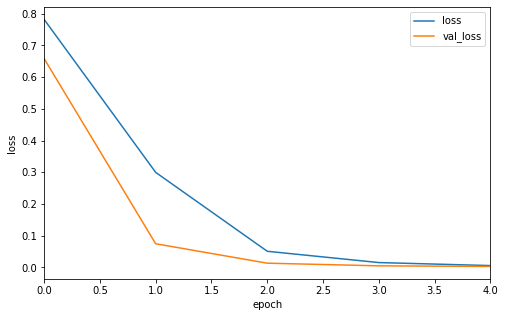

In [0]:
df_train_history.loc[:, ['loss', 'val_loss']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

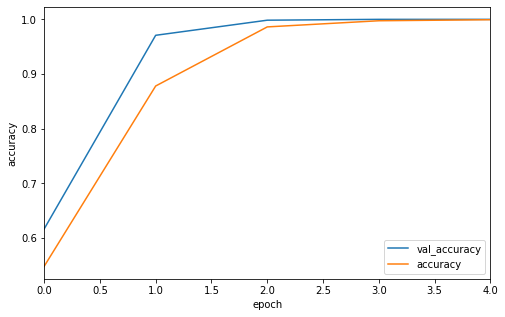

In [0]:
df_train_history.loc[:, ['val_accuracy', 'accuracy']].plot(figsize=(8, 5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [0]:
embed_test_history = embed_res_model.evaluate(X_test_padded, 
                                    y_test_one_hot, 
                                    batch_size=con.PARAMS['batch_size'], 
                                    verbose=0)

In [0]:
met.print_test_results(embed_res_model, embed_test_history)

Test Metrics:
 * Loss: 0.016619466923969168
 * TP: 104.0
 * FP: 3.0
 * TN: 812.0
 * FN: 3.0
 * Accuracy: 0.9934924244880676
 * Precision: 0.9719626307487488
 * Recall: 0.9719626307487488
 * AUC: 0.9997592568397522


In [0]:
con.PREDICTIONS['embed_res'] = embed_res_model.predict_classes(X_test_padded)

### XGBoost
The neural networks appear to do a great job of predicting negative reviews. But, to further explore models, let's compare how an XGBoost model performs compared with the pervious models.

In [0]:
x_class = XGBClassifier()
x_class.fit(X_train_vectorized, y_train)
y_pred = x_class.predict(X_test_vectorized)

In [0]:
df_predictions = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

In [0]:
cm_table = pd.crosstab(df_predictions['actual'], df_predictions['predicted'], rownames=['actual'], colnames=['predicted'])

In [0]:
print('Confussion Matrix:')
print(cm_table)

Confussion Matrix:
predicted    0   1
actual            
0          815   0
1           52  55


Let's also use five-fold cross-validation to assess the XGBoost model fit.

In [0]:
x_class = XGBClassifier()
x_class.fit(X_train_vectorized, y_train)
score = cross_validate(x_class, X_train_vectorized, y_train, cv=5)
y_pred = x_class.predict(X_test_vectorized)

In [0]:
print(f'CV Metrics: mean = {np.mean(score["test_score"]):0.3f}, std = {np.std(score["test_score"]):0.3f}')

CV Metrics: mean = 0.944, std = 0.009


The large mean score and small standard deviation indicates that the XGBoost model is giving accurate and consistent results.

### Oversampled Training Set
Repeat the model fit, but use the oversampled training set.

In [0]:
x_class = XGBClassifier()
x_class.fit(X_train_res_vects, y_train_res_vects)
y_pred = x_class.predict(X_test_vectorized)

In [0]:
df_predictions = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

In [0]:
cm_table = pd.crosstab(df_predictions['actual'], df_predictions['predicted'], rownames=['actual'], colnames=['predicted'])

In [0]:
print('Confussion Matrix:')
print(cm_table)

Confussion Matrix:
predicted    0   1
actual            
0          798  17
1           24  83


The neural networks appear to perform better than XGBoost.

## Make Predictions
Using the best model, I will make predictions of positive and negative views. The best model in this case is the oversampled MLP model using TF-IDF vectors.

In [0]:
dict_predict = {
    'text': X_test,
    'labels': con.PREDICTIONS['mlp_res'].flatten()
}

In [0]:
df_prediction = pd.DataFrame(dict_predict)

In [0]:
df_negative_reviews = df_prediction[df_prediction['labels'] == 1].copy()

In [0]:
df_negative_reviews.to_csv(os.path.join(PROJECT_PATH, 'data/negative_review_predictions.csv'), index=False)